In [1]:
# ==========================================
# 1. Import
# ==========================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
import numpy as np

In [2]:
# Reproducibilità
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
df_train = pd.read_csv("fashion-mnist_train.csv")
df_test = pd.read_csv("fashion-mnist_test.csv")

x_train = df_train.drop("label", axis=1).values
y_train = df_train["label"].values

x_test = df_test.drop("label", axis=1).values
y_test = df_test["label"].values

In [4]:
# ==========================================
# 2. Dataset
# ==========================================

# Normalizzazione e reshape in formato 4D richiesto da Conv2D
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test  = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)

Train shape: (60000, 28, 28, 1)
Test shape: (10000, 28, 28, 1)


Per la parte del breve EDA, vedere il random forest.

In [5]:
# ==========================================
# 3. Funzione per costruire il modello CNN
# ==========================================
def build_cnn(hp):
    model = Sequential()
    model.add(Input(shape=(28,28,1)))
    
    # Primo blocco conv
    model.add(Conv2D(
        filters=hp.Int("filters_1", 32, 64, step=16),
        kernel_size=(3,3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if hp.Boolean("batchnorm_1"):
        model.add(BatchNormalization())
    model.add(Dropout(hp.Float("dropout_1", 0.2, 0.5, step=0.1)))
    
    # Secondo blocco conv
    model.add(Conv2D(
        filters=hp.Int("filters_2", 64, 128, step=32),
        kernel_size=(3,3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if hp.Boolean("batchnorm_2"):
        model.add(BatchNormalization())
    model.add(Dropout(hp.Float("dropout_2", 0.2, 0.5, step=0.1)))
    
    # Flatten
    model.add(Flatten())
    
    # Dense finale
    model.add(Dense(
        units=hp.Int("dense_units", 64, 256, step=64),
        activation='relu'
    ))
    model.add(Dropout(hp.Float("dropout_dense", 0.2, 0.5, step=0.1)))
    
    # Output
    model.add(Dense(10, activation="softmax"))
    
    # Ottimizzatore
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Choice("lr", [1e-2, 1e-3, 1e-4])
    )
    
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [6]:
# ==========================================
# 4. Tuner setup
# ==========================================
tuner = kt.RandomSearch(
    build_cnn,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="tuner_results",
    project_name="fashion-mnist_cnn"
)

# Early stopping e TensorBoard
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

tensorboard_callback = TensorBoard(
    log_dir='./logs',       # cartella dove salvare i log
    histogram_freq=1        # salva istogrammi dei pesi per ogni epoca
)

In [7]:
# ==========================================
# 5. Ricerca iperparametri migliori
# ==========================================
tuner.search(
    x_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

tuner.results_summary(num_trials=3)

Trial 10 Complete [00h 03m 22s]
val_accuracy: 0.9155833125114441

Best val_accuracy So Far: 0.9206666946411133
Total elapsed time: 01h 04m 56s
Results summary
Results in tuner_results\fashion-mnist_cnn
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
filters_1: 64
batchnorm_1: True
dropout_1: 0.30000000000000004
filters_2: 128
batchnorm_2: False
dropout_2: 0.30000000000000004
dense_units: 256
dropout_dense: 0.4
lr: 0.0001
Score: 0.9206666946411133

Trial 06 summary
Hyperparameters:
filters_1: 64
batchnorm_1: False
dropout_1: 0.2
filters_2: 96
batchnorm_2: True
dropout_2: 0.2
dense_units: 64
dropout_dense: 0.2
lr: 0.0001
Score: 0.9183333516120911

Trial 03 summary
Hyperparameters:
filters_1: 48
batchnorm_1: True
dropout_1: 0.2
filters_2: 96
batchnorm_2: True
dropout_2: 0.4
dense_units: 256
dropout_dense: 0.2
lr: 0.001
Score: 0.9175000190734863


In [8]:
# ==========================================
# 6. Addestramento finale
# ==========================================
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best CNN hyperparameter found:")
print(best_hp.values)

best_model = tuner.hypermodel.build(best_hp)

history = best_model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, tensorboard_callback],
    verbose=1
)

Best CNN hyperparameter found:
{'filters_1': 64, 'batchnorm_1': True, 'dropout_1': 0.30000000000000004, 'filters_2': 128, 'batchnorm_2': False, 'dropout_2': 0.30000000000000004, 'dense_units': 256, 'dropout_dense': 0.4, 'lr': 0.0001}
Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.7237 - loss: 0.7698 - val_accuracy: 0.8305 - val_loss: 0.4786
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - accuracy: 0.8142 - loss: 0.5076 - val_accuracy: 0.8611 - val_loss: 0.3890
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.8434 - loss: 0.4335 - val_accuracy: 0.8733 - val_loss: 0.3468
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.8546 - loss: 0.3958 - val_accuracy: 0.8808 - val_loss: 0.3257
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.8648 - loss: 0.3693 - val_accuracy: 0.8867 - val_loss: 0.3080
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.8732 - loss: 0.3485 - val_accuracy: 0.8929 - val

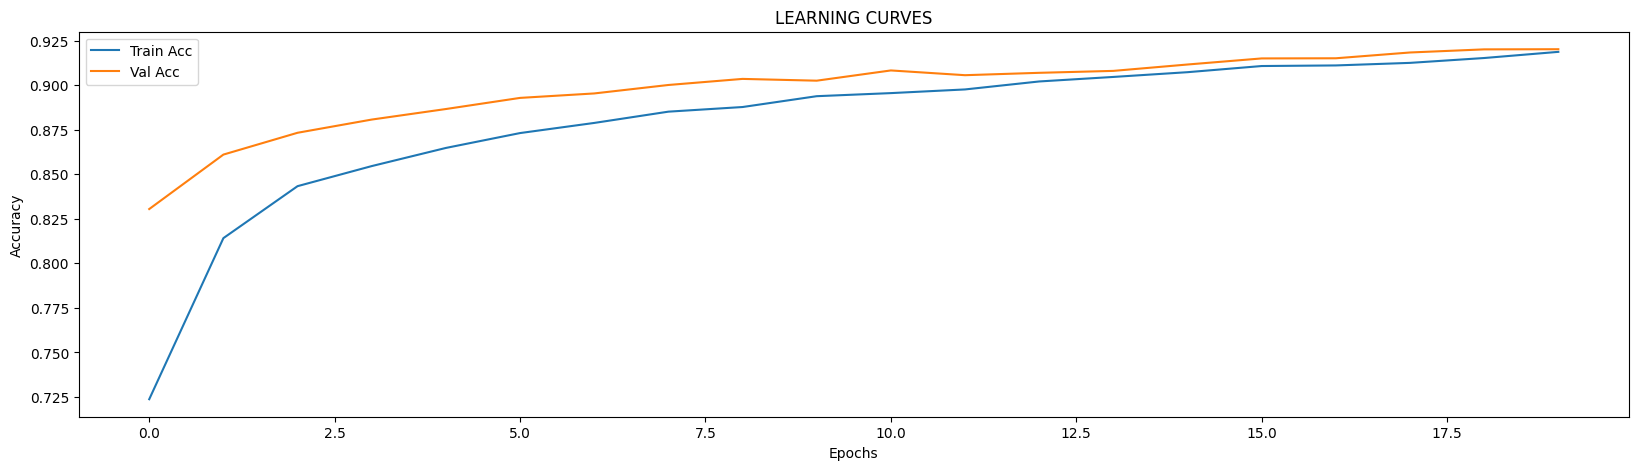

In [9]:
# ==========================================
# 7. Learning curves
# ==========================================
plt.figure(figsize=(20,5))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("LEARNING CURVES")
plt.legend()


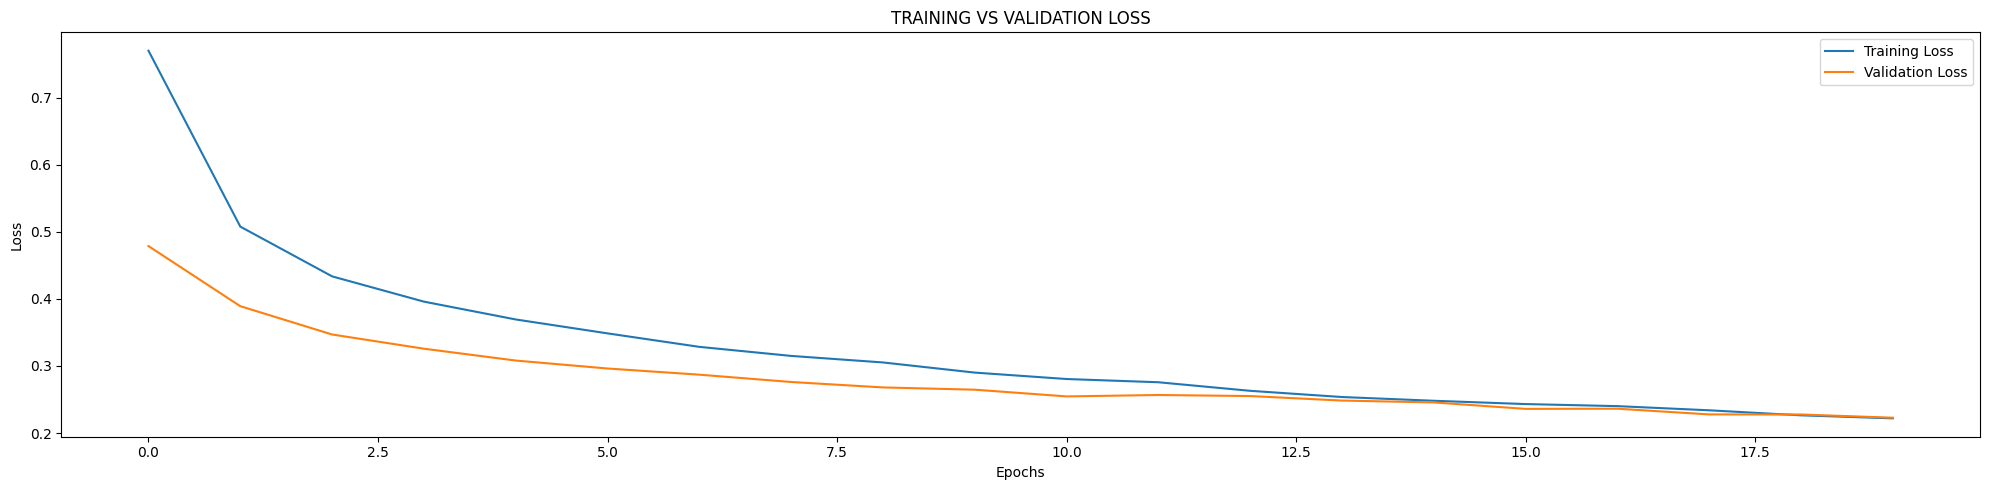

In [10]:
# === Learning Curves: Loss ===
plt.figure(figsize=(20, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('TRAINING VS VALIDATION LOSS')
plt.legend()
plt.tight_layout()

In [11]:
# Predizioni sul test set
y_pred = np.argmax(best_model.predict(x_test), axis=1)
y_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([0, 1, 2, ..., 8, 8, 1])

In [12]:
# ==========================================
# 8. Valutazione su Test
# ==========================================
loss, acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f"CNN accuracy on the test set: {100*acc:.2f}% with loss: {100*loss:.2f}%")

CNN accuracy on the test set: 92.10% with loss: 21.34%


In [13]:
#   Converto il report in un DataFrame
report = classification_report(y_true= y_test, y_pred= y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
0,0.860648,0.877,0.868747,1000.000
1,0.990982,0.989,0.989990,1000.000
2,0.911017,0.860,0.884774,1000.000
3,0.909354,0.943,0.925871,1000.000
4,0.860194,0.886,0.872906,1000.000
5,0.988832,0.974,0.981360,1000.000
6,0.784091,0.759,0.771341,1000.000
7,0.953695,0.968,0.960794,1000.000
8,0.984985,0.984,0.984492,1000.000
9,0.965174,0.970,0.967581,1000.000


In [14]:
#   Seleziono la parte che mi interessa
df_report = df_report.iloc[:-3,:-1]
df_report

,precision,recall,f1-score
0,0.860648,0.877,0.868747
1,0.990982,0.989,0.989990
2,0.911017,0.860,0.884774
3,0.909354,0.943,0.925871
4,0.860194,0.886,0.872906
5,0.988832,0.974,0.981360
6,0.784091,0.759,0.771341
7,0.953695,0.968,0.960794
8,0.984985,0.984,0.984492
9,0.965174,0.970,0.967581


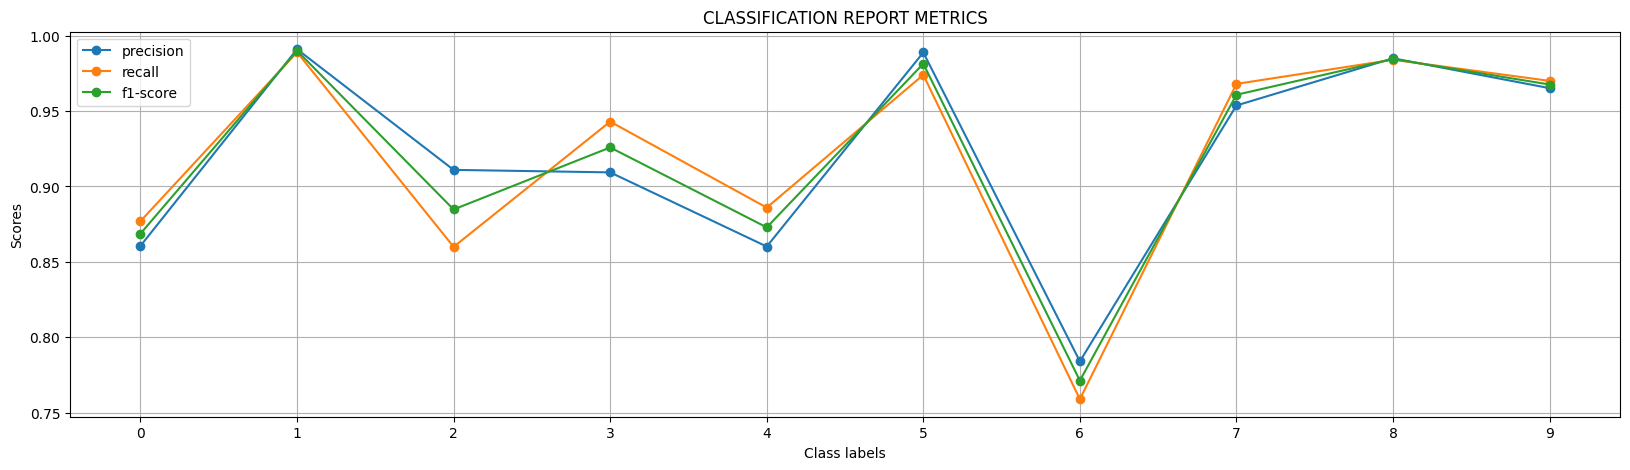

In [15]:
#   Plotting
plt.figure(figsize=(20, 5))
for metric in df_report:
    plt.plot(df_report.index, df_report.loc[df_report.index, metric], label=metric, marker='o') #   Con \"index\" accedo al nome delle righe

#   Impostazioni grafico
plt.xlabel('Class labels')
plt.ylabel('Scores')
plt.title('CLASSIFICATION REPORT METRICS')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'CONFUSION MATRIX HEATMAP')

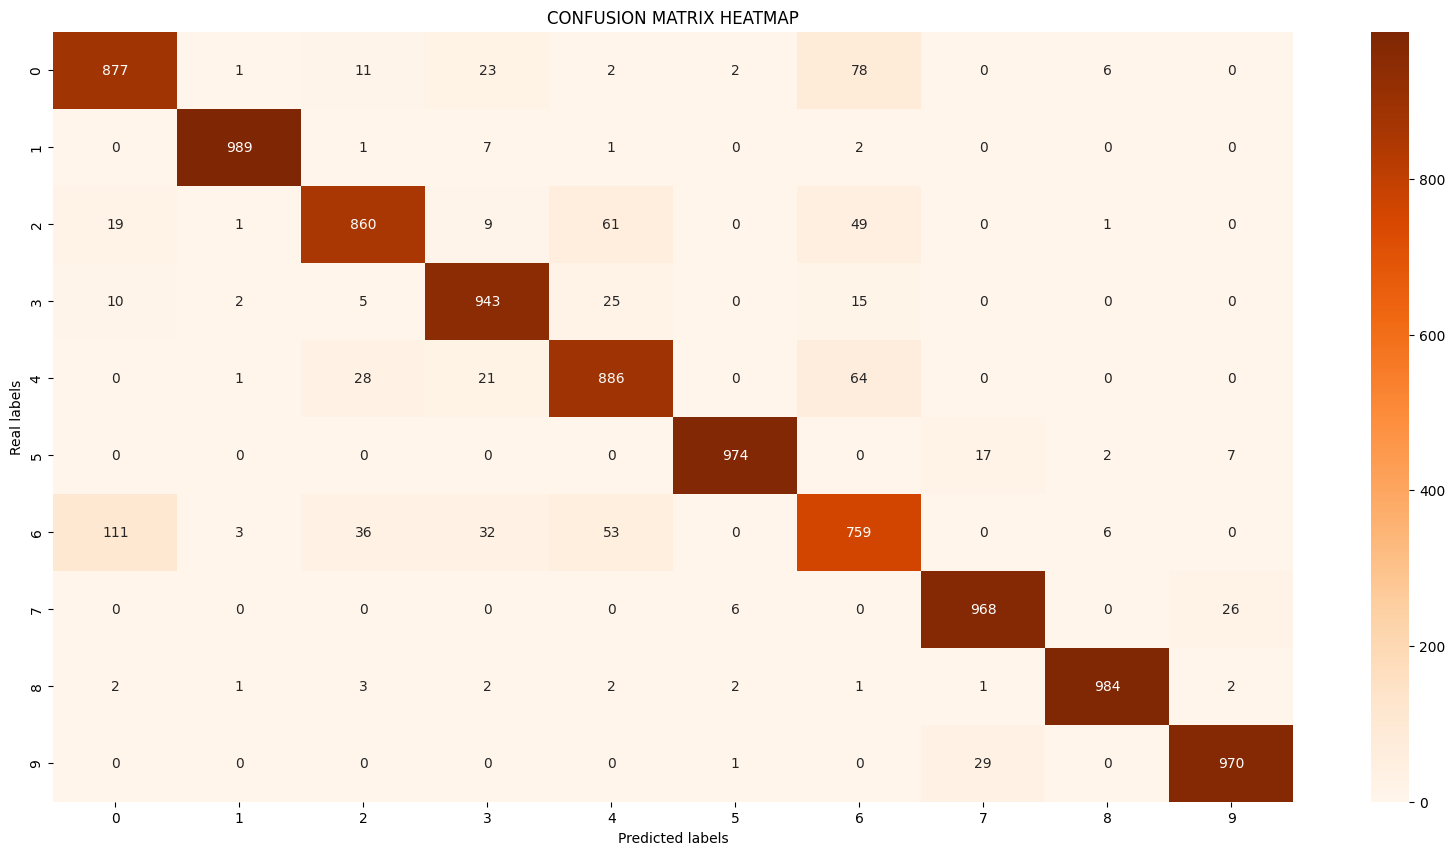

In [16]:
#   Confusion matrix
cm = confusion_matrix(y_true= y_test, y_pred= y_pred)

plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=np.sort(np.unique(y_test)), yticklabels=np.sort(np.unique(y_test)))
#    Con \"annot=True\" i numeri verranno mostrati all'interno di ciascuna cella della heatmap.
plt.xlabel('Predicted labels')
plt.ylabel('Real labels')
plt.title('CONFUSION MATRIX HEATMAP')

In [17]:
# ==========================================
# 9. Salvataggio modello
# ==========================================
best_model.save("best_mnist_cnn.keras")
print("CNN saved as 'best_mnist_cnn.keras'")


CNN saved as 'best_mnist_cnn.keras'
